# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)
library(viridis)
library(ggpubr)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [3]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

In [4]:
getPR <- function(f, alpha, pi_thr, related_taxa, all){
    
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)
     
    edi$B <- str_extract(f, pattern = '(?<=B)[:digit:]+')
    edi$seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    edi$K <- length(expanded_edges)
    edi$Ncol <- all
    
    return(edi)
}

In [5]:
getSinglePR <- function(res, alpha, pi_thr,expanded_edges, all, taxa){
    pc <- quiet(stabilitySelection(res, alpha_error = alpha, pi_thr = pi_thr))
    
    if (is.null(pc$edges_agg)){
        return(NULL)
    }
    
    # prepare edges from endoR
    suppressMessages(edges <- pc$edges_agg %>% select(x, y, condition, importance, influence, d.x, d.y) %>% 
        subset(condition %in% pc$rules_summary$condition) %>%
        group_by(x, y, condition) %>% 
        summarise(importance= mean(importance), influence = mean(influence*(d.x+d.y)/2)) %>%
        ungroup %>% 
        left_join(select(pc$rules_summary,condition, inN, imp, n), by = 'condition') %>% 
        select(-condition) )
    
    edi <- lapply(unique(edges$inN)
                  , function(i, edges,expanded_edges, all){
                      suppressMessages(edges <- edges %>% subset(inN >= i) %>% group_by(x, y) %>% 
                                       summarise( inN = max(inN), importance = sum(importance*imp*n)
                                                 , influence = sum(influence*imp*n)/sum(imp*n) ) %>% ungroup)
                      metricsNet(edges = edges,expanded_edges=expanded_edges, all=all)
                  }, edges = edges,expanded_edges=expanded_edges, all=all)
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)
    edi <- add_row(edi, n_edges=0, tp=0,fp=0,tn=0,fn=0,inN=0)
    edi$alpha <- alpha
    edi$pi_thr <- pi_thr
    
    return(edi)
}

In [6]:
getSeveralPR <- function(f, alphas, pi_thr, taxa,related_taxa, all){
    res <- qread(f)
    
    # get the true edges
    te <- lapply(res$true_edges, str_replace_all, pattern = '\\_{2}.*', replacement = '')
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- te[[i]] %>% str_replace(pattern = '\\_{2}.*', replacement = '')
        tmp <- related_taxa[tmp]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)

        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
    
    edi <- lapply( alphas , getSinglePR, res = res$resamp, pi_thr = pi_thr
                  ,expanded_edges=expanded_edges, all=all, taxa = taxa)
    
    edi <- as.data.frame(do.call(rbind, edi))
    
    edi$seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    edi$K <- length(expanded_edges)
    edi$Ncol <- all
    
    return(edi)
}

# Data

In [7]:
taxa <- qread('../../data/taxa_table.qs')

In [8]:
# location of simulations
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/p005_B10/', full.names = TRUE, pattern = 'simu')

In [9]:
related_taxa <- qread('../tmp/related_taxa_full.qs')
is_s <- str_which(names(related_taxa), pattern = '^s_')
related_taxa[is_s] <- related_taxa[is_s] %>% lapply(function(x){str_subset(x, pattern = '^s|g')})
related_taxa$groupa <- 'groupa'
related_taxa$groupb <- 'groupb'
related_taxa$groupc <- 'groupc'
related_taxa$groupd <- 'groupd'

In [10]:
length(fnames)

[1] 50

# PR curves

In [11]:
#stopCluster(cluster)
cluster <- makeCluster(5)
quiet(clusterEvalQ(cluster, library(qs)))
quiet(clusterEvalQ(cluster, library(endoR)))
quiet(clusterEvalQ(cluster, library(tidyverse)))
quiet(clusterExport(cluster, c('getSinglePR', 'metricsNet', 'quiet' )))

In [12]:
pi7_sev <- parLapply(cl = cluster,fnames, getSeveralPR, alpha = c(1,5,10, 15, 20), taxa = taxa
                     ,related_taxa=related_taxa, pi_thr = 0.7, all = (525^2-525)/2)
pi7_sev <- do.call(rbind, pi7_sev)
suppressWarnings(av_pi7 <- pi7_sev %>% group_by(alpha, inN) %>% summarise_all(mean))

In [13]:
stopCluster(cluster)

# Interpolate

In [14]:
getInterpo <- function(i, raw){
    raw <- subset(raw, seedN == i)
    res <- list()
    
    N <- (525^2-525)/2 
    K <- unique(raw$K)
    
    i <- 1
    for (a in unique(raw$alpha)){
        tmp <- approx(raw$fp[raw$alpha == a]
                       , raw$tp[raw$alpha == a]
                       , xout = seq(1, 150, length.out = 1000)
                       , ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        colnames(tmp) <- c('fp', 'tp')
        
        # add 0 and max values to the extrapolations
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        tmp$tp[tmp$fp>mafp] <- max(tmp$tp, na.rm = TRUE)
        
        tmp <- tmp[complete.cases(tmp),]
        #tmp <- tmp %>% add_row(tp = 0, fp = 0)
        tmp$alpha <- a

        res[[i]] <- tmp %>% arrange(tp)
        i <- i+1
    }
    res <- do.call(rbind, res)
    res$seedN <- i
    
    return(res)
}

In [15]:
pr7_byseed <- suppressWarnings(lapply(unique(pi7_sev$seedN), getInterpo, raw = pi7_sev))

In [16]:
pr7_byseed_av <- do.call(rbind, pr7_byseed) %>% select(-seedN) %>% group_by(fp, alpha) %>% summarise_all(mean)
pr7_byseed_sd <- do.call(rbind, pr7_byseed) %>% select(-seedN) %>% group_by(fp, alpha) %>% summarise_all(sd)

pr7_forplots <- left_join(pr7_byseed_av, pr7_byseed_sd, by = c('fp', 'alpha'), suffix = c('_av', '_sd'))

In [17]:
pr7_forplots %>% dim

[1] 5000    4

# Random curves

In [20]:
random_pr_curve <- function(K){
  N <- (525^2-525)/2 
    
  urn <- c(rep(1, K), rep(0, N-K))
  B <- 1000
  res <- list()
    
  for(j in 1:B){
    set.seed(j)
    random_draw <- urn[sample(1:N)]
    tp <- cumsum(random_draw)
    fp <- 1:N - cumsum(random_draw)
    linfit <- approx(fp, tp, xout = seq(1, 150, length.out = 1000),ties = max)
      
    tmp <- as.data.frame(do.call(cbind, linfit))
    colnames(tmp)<- c('fp', 'tp')
    # add 0 and max values to the extrapolations
    mifp <- min(tmp$fp[!is.na(tmp$tp)])
    mafp <- max(tmp$fp[!is.na(tmp$tp)])
    tmp$tp[tmp$fp<mifp] <- min(tmp$tp)
    tmp$tp[tmp$fp>mafp] <- K  
    res[[j]] <- tmp[ complete.cases(tmp), ]
  }
 
  res <- do.call(rbind, res)
  res <- res %>% group_by(fp) %>% summarise(tp = mean(tp), qtiles = quantile(tp, 0.99))
  
  return(res)
  
}

In [21]:
#stopCluster(cluster)
cluster <- makeCluster(5)
quiet(clusterEvalQ(cluster, library(qs)))
quiet(clusterEvalQ(cluster, library(tidyverse)))
quiet(clusterExport(cluster, c('random_pr_curve')))

In [22]:
Ks <- pi7_sev %>% select(K, seedN) %>% unique %>% select(K) %>% unlist
rdm <- parLapply(cluster, Ks,random_pr_curve)

In [ ]:
stopCluster(cluster)

In [ ]:
rdm_av <- do.call(rbind, rdm ) %>% group_by(fp) %>% summarise_all(mean)
rdm_sd <- do.call(rbind, rdm) %>% group_by(fp) %>% summarise_all(sd)
rdm_av <- left_join(rdm_av, rdm_sd, by = c('fp'), suffix = c('_av', '_sd'))

In [ ]:
saveRDS(rdm_av, '../tmp/alphas_rdm.RDS')

In [18]:
rdm_av <- readRDS('../tmp/alphas_rdm.RDS')

# plots

In [19]:
cols <- plasma(length(unique(pr7_forplots$alpha)) + 2)

In [20]:
p <- ggplot(pr7_forplots %>% subset(fp < 100) 
             , aes(x = fp, y = tp_av, group = as.factor(alpha), color = as.factor(alpha)))+

geom_hline(yintercept = 9, color = 'lightgrey', linetype = 'dashed')+

geom_line(data = rdm_av %>% subset(fp < 100), aes(y = tp_av, x = fp), group=NA, color = 'darkgrey')+
geom_ribbon(data = rdm_av %>% subset(fp < 100)
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2, y = tp_av
                  , group=NULL, color = NULL)
            , alpha = 0.25, fill = 'darkgrey') +
geom_line(size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = alpha, fill = as.factor(alpha)), color = NA
            , alpha = 0.25) +

geom_point(data = av_pi7 %>% subset(inN == 7)
           , aes(y = tp, x = fp, fill = as.factor(alpha))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP')+
scale_color_manual(values = cols[-c(1, length(cols))], name = expression(alpha)) +
scale_fill_manual(values = cols[-c(1, length(cols))], name = expression(alpha)) 

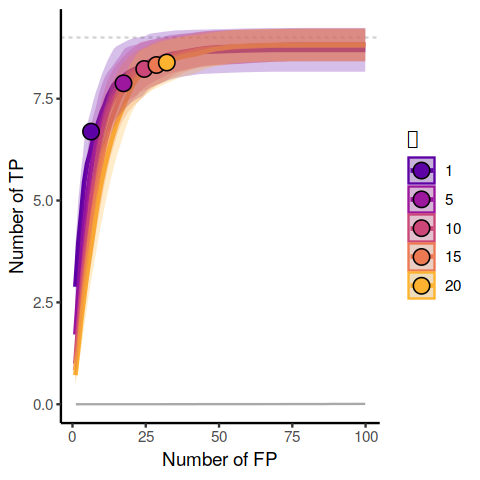

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
p

# misc

In [22]:
getRes <- function(f, alphas = c(1, 5, 10, 15,20), related_taxa){
    pre_res <- qread(f)
    
    # get the true edges
    te <- lapply(pre_res$true_edges, str_replace_all, pattern = '\\_{2}.*', replacement = '')
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- te[[i]] %>% str_replace(pattern = '\\_{2}.*', replacement = '')
        tmp <- related_taxa[tmp]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)

        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
    
    res <- list()
    
    for (a in alphas){
        
        # get the new metrics
        pc <- quiet(stabilitySelection(pre_res$resampled, alpha_error = a, pi_thr = 0.7))
    
        #if (is.null(pc$rules_summary)){
        #    return(NULL)
        #}
    
        cond <- pc$rules_summary %>% subset(inN >= 7, select = condition) %>% unlist
        if (length(cond) > 0){

            imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
            imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
            imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
            suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
            imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
            imp_edges <- lapply(imp_edges, sort) 
            pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 
            imp_edges <- sapply(imp_edges, function(x)x['importance']) 

            # those that should not be but are = in pred_edges but not truth
            fp <- sum(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
            tp <- sum(sapply(expanded_edges, function(x){ifelse(sum(x %in% pred_edges) > 0, 1, 0)}))
            fn <- sum(sapply(names(expanded_edges), function(x){!(x %in% pred_edges)}))


            # sum of FP importances
            if(fp > 0) {
                fp_imp <- which(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
                fp_imp <- sum(as.numeric(imp_edges[fp_imp]))
            } else {fp_imp <- 0}
            # sum of TP importances
            if(tp > 0) {
                tp_imp <- list()
                for (i in 1:length(expanded_edges)){
                    tp_imp[[i]] <- mean(as.numeric(imp_edges[which(pred_edges %in% expanded_edges[[i]])]))
                }
                tp_imp <- sum(unlist(tp_imp), na.rm = TRUE)
            } else {tp_imp <- 0}

            res[[as.character(a)]] <- c('alpha' = a, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = length(cond)
                    , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = tp, 'fp' = fp
                    , 'fn' = fn)
        } else {
            res[[as.character(a)]] <- c('alpha' = a, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = 0
                    , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
        }
                                                   
    }
    
    res <- do.call(rbind, res)
    
    return(res)
}

In [23]:
check <- lapply(fnames, getRes, related_taxa = related_taxa)
check <- as.data.frame(do.call(rbind, check))

In [24]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [25]:
check %>% tail

,alpha,rf_accuracy,n_decisions,tp_imp,fp_imp,tp,fp,fn,precision,recall,w_precision
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X20.48,20,0.9188951,66,591.7498,104.98989,9,45,2,0.1666667,0.8181818,0.8493126
X1.49,1,0.9285351,8,137.4198,22.39393,4,5,6,0.4444444,0.4000000,0.8598748
X5.49,5,0.9285351,18,217.6505,58.52426,9,14,2,0.3913043,0.8181818,0.7880898
X10.49,10,0.9285351,30,302.4924,73.01542,9,21,2,0.3000000,0.8181818,0.8055555
X15.49,15,0.9285351,39,314.1780,78.85514,9,28,2,0.2432432,0.8181818,0.7993677
X20.49,20,0.9285351,44,294.7985,86.05052,9,32,2,0.2195122,0.8181818,0.7740561


In [26]:
check %>% group_by(alpha) %>% summarise_all(mean, na.rm = TRUE) %>% #subset(alpha != 10) %>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9058784,13.52,5.98,5.42,3.36,199.4929,10.57733,0.5785970,0.6421162,0.9260560
0.9058784,26.10,7.76,17.42,1.82,225.5561,20.34507,0.3400354,0.8169406,0.8989458
0.9058784,35.12,8.12,24.22,1.42,225.1526,23.93220,0.2820590,0.8586744,0.8819917
0.9058784,42.14,8.20,28.78,1.34,222.7476,26.16670,0.2493476,0.8675633,0.8720742
0.9058784,48.30,8.26,32.52,1.30,219.4942,27.68999,0.2306994,0.8730431,0.8658533


In [27]:
check %>% group_by(alpha) %>% summarise_all(sd, na.rm = TRUE) %>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02310016,5.470664,2.142762,3.703776,2.220131,143.6663,9.540971,0.18435851,0.2389765,0.08341997
0.02310016,9.463679,1.756155,8.689872,1.976288,137.3991,17.180169,0.11138452,0.2017214,0.07610635
0.02310016,12.894612,1.598979,11.258176,1.852632,134.3077,18.114229,0.10520535,0.1910722,0.09038170
0.02310016,15.388851,1.525297,12.434793,1.813892,133.6264,18.900509,0.09838827,0.1856247,0.09361102
0.02310016,17.708813,1.454199,14.494531,1.798525,132.4889,19.741646,0.09550695,0.1809680,0.09257037


In [28]:
check[ complete.cases(check), ] %>% count(alpha)

alpha,n
<dbl>,<int>
1,50
5,50
10,50
15,50
20,50
